## Шаг 1: Считываю файлы

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from scipy import stats as st

In [128]:
df = pd.read_csv('games.csv')

## Шаг 2: Подготавливаю данные

In [129]:
# Привожу названия столбцов к нижнему регистру
df.columns = map(str.lower, df.columns)

In [130]:
# Проверю тип данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [131]:
# Проверю NaN
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Удалю строки где есть NaN в столбце 'year_of_release', т.к. значений всего 269 (1.6% от всех данных), то и на статистику они не повлияют. Можно было взять года и названий игр, но не всегда года в названиях игр совпадают с их выпуском.  
В 'name' и 'genre' тоже удалю, т.к. значений всего два в каждом.  
Причиной пропусков может быть человеческий фактор. Или данные не загрузились должным образом.

In [132]:
# Удаляю
df.dropna(subset=['year_of_release', 'name', 'genre'], inplace=True)

Заменю NaN в столбце 'critic_score'. Сначала посмотрю, для каких платформ есть NaN. В переменной cs хранится лист с названиями платформ, где рейтинги NaN.  
Причиной пропусков может быть то, что просто не ставили оценки, либо данных слишком мало. Либо в некоторых странах не ставили оценки.

In [133]:
cs = df.groupby('platform')['critic_score'].count().reset_index()
cs = cs[cs['critic_score'] == 0].reset_index(drop=True)['platform'].to_list()
cs  # Это список с платформами, где рейтинга вообще нет, т.е. только NaN

['2600',
 '3DO',
 'GB',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PCFX',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS']

Теперь в основном df заменю NaN в critic_score на нули только в тех платформах, где рейтинга вообще не было. Лист с такими платформами хранится в переменной cs (см. код выше).

Посмотрю еще на всякий случай, где еще будут NaN.

In [134]:
df.query('platform in (@cs)').isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       1097
user_score         1097
rating             1097
dtype: int64

Получается, что в столбцах user_score и rating та же самая проблема!

In [135]:
# Заменяю NaN на нули в citing_score и user_score
df.loc[df['platform'].isin(cs), ['critic_score', 'user_score']] = 0
# Заменяю NaN на '-' в rating
df.loc[df['platform'].isin(cs), 'rating'] = '-'
# Проверяю. Все получилось.
df.query('platform in (@cs)').isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Теперь заменяю NaN в critic_score по группам из platform на median.

In [136]:
# Заменяю
df['critic_score'] = df.groupby('platform')['critic_score'].transform(lambda x: x.fillna(x.median()))
# Проверяю
df['critic_score'].isna().sum()

0

Теперь столбец user_score. Первое, что сделаю, поменяю значения tbd (to be determined) на NaN, потому-что потом буду менять эти значения на медианы по группам из platform. Затем преобразую из object в float, потому-что рейтинг не целочисленный.

In [137]:
# Заменяю значения tbd в столбце user_score на NaN
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [138]:
# Меняю на float
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [139]:
# Теперь заменю на медиану по группам platform
df['user_score'] = df.groupby('platform')['user_score'].transform(lambda x: x.fillna(x.median()))
# Проверяю
df['user_score'].isna().sum()

0

Теперь столбец rating. В нем заменю NaN на '-'. B начале была идея заменить на значени из genre, которые известны, но простая проверка показала, что, например у жанра 'Sport' несколько уникальных значений rating. Покажу на примере снизу.  Причиной пропусков может быть то, что рейтинг в некоторые года просто не определяли. 

In [140]:
# Пример
df[(df['genre'] == 'Sports') & (df['rating'] != '-')]['rating'].unique()

array(['E', nan, 'E10+', 'T', 'M'], dtype=object)

Меняю NaN на '-'.

In [141]:
# Меняю NaN на '-'
df.loc[df['rating'].isna(), 'rating'] = '-'
# Проверяю
df['rating'].isna().sum()

0

In [142]:
# Поменяю float на int в столбце year_of_release, потому-что год дробным не бывает
df['year_of_release'] = df['year_of_release'].astype('int')

In [143]:
# Возвращаю индексы
df.reset_index(drop=True, inplace=True)

In [144]:
# Считаю суммарные продажи во всех регионах и записываю их в отдельный столбец
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [145]:
# Результат по подготовке данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


In [146]:
# Результат по подготовке данных
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,64.712692,6.883161,0.536023
std,5.875525,0.818378,0.506716,0.311100,0.188005,19.984363,2.133131,1.558786
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,65.000000,7.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,69.000000,7.400000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,73.500000,8.000000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


### Вывод

Заменил NaN на значения, соответствующие моим логическим рассуждениям. Поменял типы столбцов. Назвал возможные причины наличия пропусков.  
'tbd' в столбце user_score тоже был обработан.

## Шаг 3: Провожу исследовательский анализ данных

### Сколько игр выпускалось в разные года. Важны ли данные за все периоды?

In [147]:
# Вывожу количество выпущенных игр по всем возможным годам
df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


Чтобы понять, какие года важны, построю график и найду тренд.

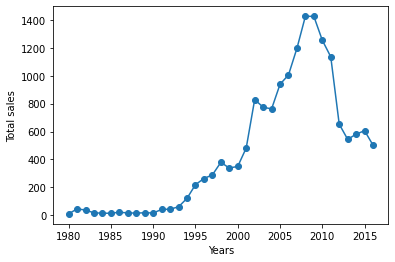

In [148]:
x = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()['year_of_release']
y = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()['name']
plt.plot(x, y, marker='o')
plt.ylabel('Total sales')
plt.xlabel('Years')
plt.show()

Для будущей оценки лучше взять года по нисходящему тренду, который начинается с 2010 года.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [149]:
# Выбираю платформы с наибольшими суммарными продажами
top10 = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
# Выбираю 10 первых платформ
top10_list = top10.loc[:10,'platform'].to_list()
top10_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS', 'PC']

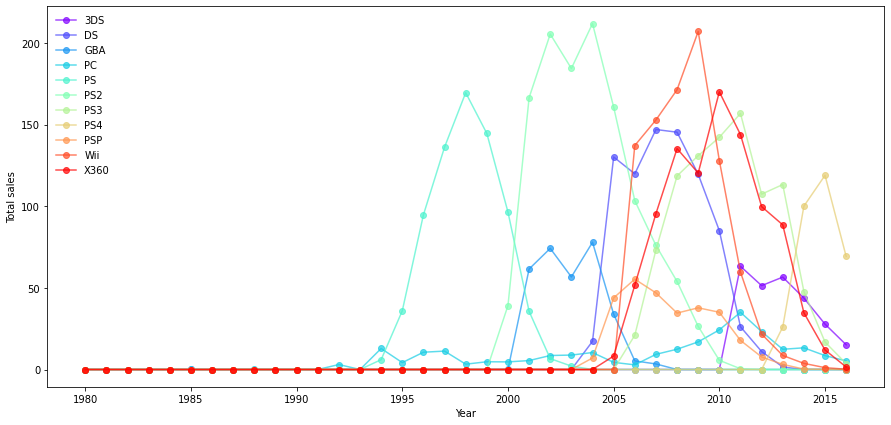

In [150]:
# Создаю новый df где будут храниться столбцы (год), строки (платформы), значения в ячейках (продажи по годам)
df_year_sales = df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').reset_index()
# Беру только топ-10
df_year_sales_top_10 = df_year_sales.query('platform in (@top10_list)').fillna(value=0).reset_index(drop=True)
# Строю графики
fig, ax = plt.subplots(figsize=(15,7))
n=len(df_year_sales_top_10)
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(len(df_year_sales_top_10)): 
    ax.plot(df_year_sales_top_10.columns.to_list()[1:], 
            df_year_sales_top_10.iloc[i, 1:], c=next(color),
            marker='o',
            alpha=0.7,
            label=df_year_sales_top_10['platform'][i])

ax.legend(frameon=False)
ax.set_xlabel('Year')
ax.set_ylabel('Total sales')
plt.show()

Ответ на вопрос: характерный срок появления новых платформ примерно 5-10 лет. Некоторые платформы, например PS2, PSP, PS3, X360 пользуются популярностью 10 лет и более. Пик популярностью платформ меняется с периодичностью 8-10 лет. Менее популярноые платформы, например GBA и 3DS, пользуются популярностью в среднем 5-7 лет. Когда выходит новая коноль, продажи старой сразу падают.

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Возьму данные, начиная с 2010 года. Беру данные c 2010 года, потому-что тренд продаж пошел на спад именно с 2010 года.

In [151]:
# Фильтрую таблицу
df_new = df[df['year_of_release']>=2010]
df_new.reset_index(drop=True, inplace=True)

### Не учитывайте в работе данные за предыдущие годы.

In [152]:
# Теперь это новая таблица
df_new

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
1,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
2,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
3,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,66.0,7.4,-,15.13
4,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
...,...,...,...,...,...,...,...,...,...,...,...,...
5272,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.0,7.6,-,0.01
5273,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,71.0,7.6,-,0.01
5274,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,73.0,7.1,-,0.01
5275,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.0,7.6,-,0.01


### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Чтобы ответить на вопрос 'Какие платформы лидируют по продажам, растут или падают?', нужно обратиться к графику выше. Повторю лист с топ-10 платформ по продажам: 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS', 'PC'.

Теперь отвечаю на вопрос по поводу потенциально прибыльных платформ.

In [153]:
# Создам сводную таблицу, чтобы ответить на вопрос
df_top_income = df_new.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
df_top_income

,platform,total_sales
0,PS3,587.74
1,X360,550.41
2,PS4,314.14
3,3DS,257.81
4,Wii,222.97
5,XOne,159.32
6,DS,123.75
7,PC,121.96
8,WiiU,82.19
9,PSP,64.05


In [154]:
list_top_income = df_top_income['platform'][:8].to_list()
# Лист где хранится топ-10 прибыльных платформ
list_top_income

['PS3', 'X360', 'PS4', '3DS', 'Wii', 'XOne', 'DS', 'PC']

Выберу первые 8 платформ, поскольку на мой взгляд они самые прибыльные.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Строю boxplot. Поскольку разбросы большие, то возьму логарифм по оси y.

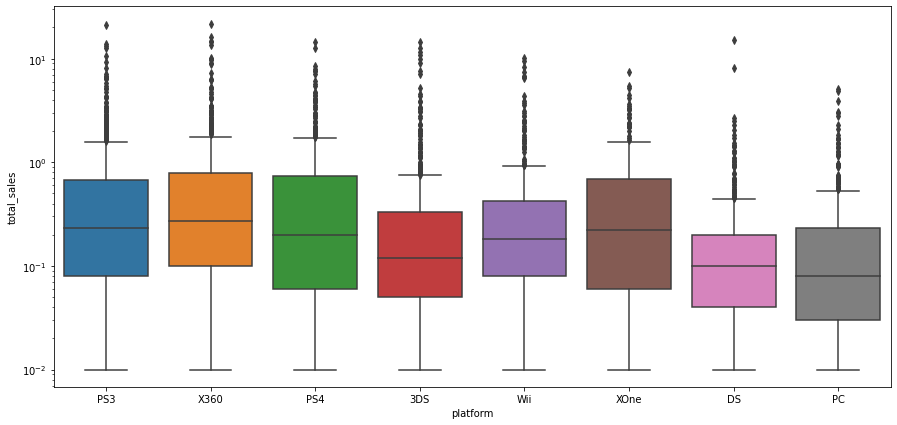

In [155]:
# Строю
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.boxplot(x='platform', 
                 y='total_sales', 
                 order=list_top_income, 
                 data=df_new.query('platform in @list_top_income'))
ax.set_yscale('log')
plt.show()

Описываю результат. Можно сказать, что продажи платформ начинались с нуля (что очевидно), у каждой платформы есть выбросы (что тоже очевидно). Больше тут нечего сказать.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для ответа на этот вопрос выберу платформу PS3.

Строю диаграмму рассеяния между отзывами и продажами.

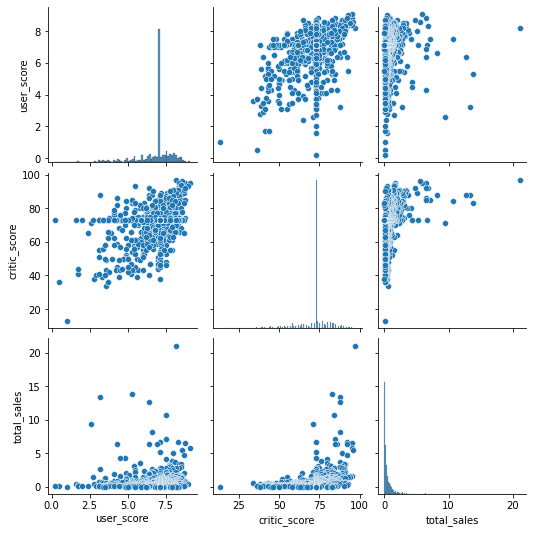

In [156]:
# Построю диаграмму рассеяния для user_score и critic_score по платформе PS3
df_PS3 = df_new.query('platform == "PS3"')
sns.pairplot(df_PS3[['user_score', 'critic_score','total_sales']])
plt.show()

Корреляция не наблюдается ни по одной из пар. Проверю еще коэф. Пирсона.

In [157]:
print(df_PS3['user_score'].corr(df_PS3['total_sales']))
print(df_PS3['critic_score'].corr(df_PS3['total_sales']))

0.014692050059624663
0.33430209283581563


Действительно, корреляции сильной нет.

Вывод: отзывы не влияют на продажи.

### Соотнесите выводы с продажами игр на других платформах.

Повторю тоже самое для X360.

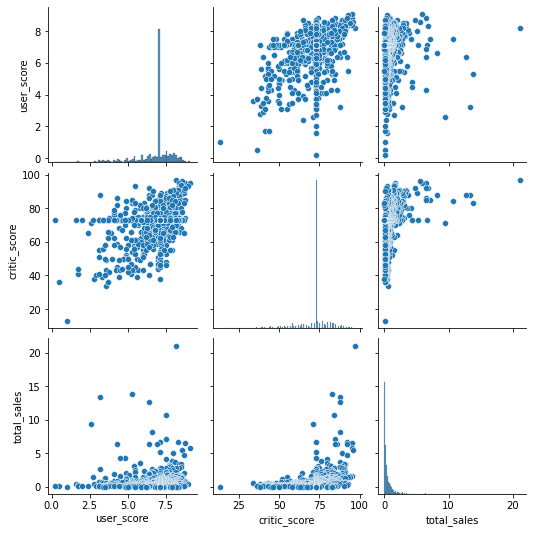

In [158]:
# Построю диаграмму рассеяния для user_score и critic_score по платформе X360
df_X360 = df_new.query('platform == "X360"')
sns.pairplot(df_PS3[['user_score', 'critic_score','total_sales']])
plt.show()

Коэффициент Пирсона.

In [159]:
print(df_X360['user_score'].corr(df_X360['total_sales']))
print(df_X360['critic_score'].corr(df_X360['total_sales']))

0.027273647545925272
0.3004872342568925


Вывод: отзывы не влияют на продажи.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [160]:
# Сводная таблица по прибыли и в зависимости от платформы и жанра
df_new.pivot_table(index='platform', columns='genre', values='total_sales', aggfunc='sum').sort_values(by='Action')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
platform,,,,,,,,,,,,
PS2,1.41,0.36,0.49,0.06,0.33,NaN,NaN,0.02,0.06,NaN,3.36,NaN
PSP,15.30,6.09,3.81,4.08,0.49,0.08,0.87,20.07,1.00,0.94,8.19,3.13
PSV,17.02,3.84,2.62,4.43,2.56,0.18,2.51,12.15,3.88,0.08,4.19,0.35
WiiU,19.07,0.17,6.27,12.46,21.53,1.32,7.87,2.89,6.01,0.20,3.16,1.24
PC,21.64,2.02,0.13,0.91,0.32,0.65,2.70,28.50,24.96,15.59,7.16,17.38
DS,22.75,7.65,0.97,18.12,6.41,10.16,3.38,35.97,1.30,9.13,3.49,4.42
XOne,37.31,2.68,2.45,7.43,0.93,NaN,9.79,10.55,60.33,0.69,26.74,0.42
Wii,42.79,3.34,1.78,87.01,29.22,2.58,5.15,4.17,4.36,3.52,37.40,1.65
3DS,57.84,4.83,10.56,10.99,32.53,5.57,14.87,84.20,1.22,26.96,6.15,2.09


То, что выделяется сразу.  
Жанры с самыми высокими показателями по продажам (прибыльные): Action, Shooter, Sports.  
Жанры с самыми низкими показателями по продажам (не прибыльные): Puzzle, Simulation, Strategy.  
Очевидно, что приставки покупают не для того, чтобы собирать пазлы на телевизоре.

## Шаг 4: Составляю портрет каждого пользователя

### Самые популярные платформы (топ-5). Опишите различия в долях продаж

In [161]:
# Поскольку надо сделать одно и то же действие для разных sales (три раза), то создам функцию (жизненный опыт научил)
def popular_platforms(dataframe, column_name): 
    # Нахожу топ-5 популярных платформ
    func_df = dataframe.pivot_table(index='platform', 
                                    values=column_name, 
                                    aggfunc='sum').sort_values(by=column_name, ascending=False).reset_index().iloc[0:5]
    # Нахожу долю от продаж
    func_df[column_name] = func_df[column_name]/func_df[column_name].sum()
    return func_df

#### Для na_sales

In [162]:
df_na_sales_top5 = popular_platforms(df_new, 'na_sales')
df_na_sales_top5

,platform,na_sales
0,X360,0.376970
1,PS3,0.258604
2,Wii,0.136719
3,PS4,0.122664
4,XOne,0.105043


#### Для eu_sales

In [163]:
df_eu_sales_top5 = popular_platforms(df_new, 'eu_sales')
df_eu_sales_top5

,platform,eu_sales
0,PS3,0.327191
1,X360,0.250310
2,PS4,0.216121
3,PC,0.105418
4,Wii,0.100960


#### Для jp_sales

In [164]:
df_jp_sales_top5 = popular_platforms(df_new, 'jp_sales')
df_jp_sales_top5

,platform,jp_sales
0,3DS,0.399571
1,PS3,0.235327
2,PSP,0.167580
3,DS,0.110793
4,PSV,0.086729


Для понимания долей объединю все таблицы.

In [165]:
df_na_sales_top5.merge(df_eu_sales_top5,
                       how='outer',
                       on='platform').merge(df_jp_sales_top5,
                                            how='outer',
                                            on='platform')

,platform,na_sales,eu_sales,jp_sales
0,X360,0.376970,0.250310,NaN
1,PS3,0.258604,0.327191,0.235327
2,Wii,0.136719,0.100960,NaN
3,PS4,0.122664,0.216121,NaN
4,XOne,0.105043,NaN,NaN
5,PC,NaN,0.105418,NaN
6,3DS,NaN,NaN,0.399571
7,PSP,NaN,NaN,0.167580
8,DS,NaN,NaN,0.110793
9,PSV,NaN,NaN,0.086729


Вывод.  
Доли продаж можно посмотреть в таблице, но, что более интересно это то, что в Японии не были представлены такие платформы как PS4, X360 Wii, XOne. А в Европе наоборот, не были представлены такие платформы как 3DS, PSP, DS, PSV. Видимо популярность в разных регионах была разной.

### Самые популярные жанры (топ-5). Поясните разницу.

Создам функцию.

In [166]:
def genre_top5(dataframe, column_name):
    func_df = dataframe.pivot_table(index='genre',  
                                    values=column_name, aggfunc='sum').sort_values(by=column_name, 
                                                                                   ascending=False).reset_index().iloc[0:5]
    return func_df

#### Для na_sales

In [167]:
df_na_genres_top5 = genre_top5(df_new, 'na_sales')
df_na_genres_top5

,genre,na_sales
0,Action,290.64
1,Shooter,237.47
2,Sports,156.81
3,Misc,123.80
4,Role-Playing,112.05


#### Для eu_sales

In [168]:
df_eu_genres_top5 = genre_top5(df_new, 'eu_sales')
df_eu_genres_top5

,genre,eu_sales
0,Action,233.63
1,Shooter,171.45
2,Sports,116.84
3,Role-Playing,75.48
4,Misc,66.09


#### Для jp_sales

In [169]:
df_jp_genres_top5 = genre_top5(df_new, 'jp_sales')
df_jp_genres_top5

,genre,jp_sales
0,Role-Playing,103.54
1,Action,72.20
2,Misc,24.29
3,Platform,15.81
4,Adventure,15.67


Объединю таблицы.

In [170]:
df_na_genres_top5.merge(df_eu_genres_top5,
                        how='outer',
                        on='genre').merge(df_jp_genres_top5,
                                             how='outer',
                                             on='genre')

,genre,na_sales,eu_sales,jp_sales
0,Action,290.64,233.63,72.20
1,Shooter,237.47,171.45,NaN
2,Sports,156.81,116.84,NaN
3,Misc,123.80,66.09,24.29
4,Role-Playing,112.05,75.48,103.54
5,Platform,NaN,NaN,15.81
6,Adventure,NaN,NaN,15.67


Вывод.  
Жанр action доминировал в na_sales и eu_sales. В jp_sales доминировал role-playing (видимо японцы любят экзотику). Японцы в шутеры и спорт вообще не играют, а action у них идет на втором месте.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Создам функцию.

In [171]:
def rating(dataframe, column_name):
    func_df = dataframe.pivot_table(index='rating',  
                                    values=column_name, aggfunc='sum').sort_values(by=column_name, 
                                                                                   ascending=False).reset_index()
    return func_df

#### Для na_sales

In [172]:
df_na_rating = rating(df_new, 'na_sales')
df_na_rating

,rating,na_sales
0,M,382.22
1,E,271.15
2,T,160.81
3,E10+,159.38
4,-,155.72
5,EC,1.13
6,RP,0.00


#### Для eu_sales

In [173]:
df_eu_rating = rating(df_new, 'eu_sales')
df_eu_rating

,rating,eu_sales
0,M,292.04
1,E,197.34
2,-,139.44
3,T,113.08
4,E10+,99.28
5,RP,0.03
6,EC,0.00


#### Для jp_sales

In [174]:
df_jp_rating = rating(df_new, 'jp_sales')
df_jp_rating

,rating,jp_sales
0,-,171.49
1,E,47.87
2,T,42.11
3,M,30.45
4,E10+,13.22
5,EC,0.00
6,RP,0.00


Объединяю таблицы.

In [175]:
df_na_rating.merge(df_eu_rating,
                   how='outer',
                   on='rating').merge(df_jp_rating,
                                     how='outer',
                                     on='rating')

,rating,na_sales,eu_sales,jp_sales
0,M,382.22,292.04,30.45
1,E,271.15,197.34,47.87
2,T,160.81,113.08,42.11
3,E10+,159.38,99.28,13.22
4,-,155.72,139.44,171.49
5,EC,1.13,0.00,0.00
6,RP,0.00,0.03,0.00


Вывод.  
Тут ситуация двоякая. Не факт, что именно рейтинг влияет на продажи. Рейтинг то завязан на жанре. Но, если исходить из таблицы выше, то можно сказать, что игры с рейтингом M самые популярные (за исключением Японии). Есть еще рейтинги без оценок, но их не будем учитывать.

## Шаг 5: Проверяю гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформы xbox one и pc одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги платформа xbox one и pc разные.

In [176]:
# Тут хранятся рейтинги по xbox
user_score_xbox = df_new[df_new['platform'] == 'XOne']['user_score'].reset_index(drop=True).to_list()
# Тут хранятся рейтинги по PC
user_score_pc = df_new[df_new['platform'] == 'PC']['user_score'].reset_index(drop=True).to_list()

Проверю гипотезу для того, чтобы оценить статистическую значимость разницы в средних между выборками (в данном случае это и есть критерий).

In [177]:
# Задаю критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

alpha = .05

results = st.ttest_ind(user_score_xbox, user_score_pc, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1677383282347323
Не получилось отвергнуть нулевую гипотезу


Вывод.  
Оснований полагать, что пользовательский рейтинг у xbox статистически значимо выше чем у pc - нет.

### Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза: средние пользовательские рейтинги жанров action и sports одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги жанров action и sports разные.  

In [178]:
# Тут хранятся рейтинги по action
user_score_action = df_new[df_new['genre'] == 'Action']['user_score'].reset_index(drop=True).to_list()
# Тут хранятся рейтинги по sports
user_score_sports = df_new[df_new['genre'] == 'Sports']['user_score'].reset_index(drop=True).to_list()

Проверю гипотезу для того, чтобы оценить статистическую значимость разницы в средних между выборками (в данном случае это и есть критерий).

In [179]:
# Задаю критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

alpha = .05

results = st.ttest_ind(user_score_action, user_score_sports, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.927942252012442e-14
Отвергаем нулевую гипотезу


Вывод.  
Альтернативная гипотеза подтверждена - средние пользовательские рейтинги жанров action и sports разные.

## Общий вывод

Данные были подготовлены к анализу.  
Были выполнены все задания: найдены популярные платформа по разным регионам, популярные жанры по регионами, и т.д.  
Были проверены нулевые и альтернативные гипотезы.  
По каждому пункту был написан вывод.